In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
N_ROWS = 3
N_COLS = 4

WALL = (1, 1)
GOAL = (0, 3)
PIT  = (1, 3)

In [3]:
ACTIONS = {
    'up':    (-1,  0),
    'down':  ( 1,  0),
    'left':  ( 0, -1),
    'right': ( 0,  1)
}

In [4]:
SLIP_LEFT = {'up': 'left', 'left': 'down', 'down': 'right', 'right': 'up'}
SLIP_RIGHT= {'up': 'right','right': 'down','down': 'left','left': 'up'}


In [5]:
def build_states():
    """Return list of valid states (row, col) excluding wall."""
    states = []
    for r in range(N_ROWS):
        for c in range(N_COLS):
            if (r, c) == WALL:
                continue
            states.append((r, c))
    return states

STATES = build_states()

In [6]:
def build_rewards(living_penalty=0.04):
    """
    Build the reward table:
      - Goal: +1
      - Pit: -1   <-- chosen intentionally (the assignment doc had `1` which is likely a typo)
      - Others (non-terminal): living_penalty (positive or negative depending on experiment)
    """
    R = {}
    for s in STATES:
        if s == GOAL:
            R[s] = +1.0
        elif s == PIT:
            R[s] = -1.0
        else:
            R[s] = -living_penalty if living_penalty >= 0 else living_penalty * -1

    return R


In [7]:
def is_terminal(s):
    return s == GOAL or s == PIT

def valid_state(s):
    r, c = s
    if r < 0 or r >= N_ROWS or c < 0 or c >= N_COLS:
        return False
    if s == WALL:
        return False
    return True

In [8]:
def get_next_states(state, action):
    """
    Given state (r,c) and intended action (string), return list of (prob, next_state).
    Stochastic model:
      - 0.8 intended direction
      - 0.1 slip left (90 deg)
      - 0.1 slip right
    If a movement would hit wall or outside grid -> agent stays in current state.
    If current state is terminal -> it stays there with prob 1.
    """
    if is_terminal(state):
        return [(1.0, state)]

    outcomes = [
        (0.8, action),
        (0.1, SLIP_LEFT[action]),
        (0.1, SLIP_RIGHT[action])
    ]

    result = {}
    for prob, act in outcomes:
        dr, dc = ACTIONS[act]
        nr, nc = state[0] + dr, state[1] + dc
        next_s = (nr, nc)
        if not valid_state(next_s):
            next_s = state
        result[next_s] = result.get(next_s, 0.0) + prob

    return [(p, s) for s, p in result.items()]


In [9]:
def value_iteration(states, actions, get_next_states_fn, rewards, gamma=0.99, theta=1e-4):
    """
    Run Value Iteration.

    states: list of valid (r,c) states
    actions: list of action names
    get_next_states_fn(s,a) -> list of (prob, s')
    rewards: dict mapping state -> immediate reward for being in that state
    gamma: discount factor
    theta: stopping threshold (max change)
    """

    V = {s: 0.0 for s in states}

    iteration = 0
    while True:
        delta = 0.0
        iteration += 1
        V_prev = V.copy()

        for s in states:
            if is_terminal(s):
                V[s] = rewards[s]
                continue

            q_values = []
            for a in actions:
                q_sa = 0.0
                for prob, s_next in get_next_states_fn(s, a):
                    r = rewards[s_next]
                    q_sa += prob * (r + gamma * V_prev[s_next])
                q_values.append(q_sa)

            best_q = max(q_values)
            V[s] = best_q
            delta = max(delta, abs(V_prev[s] - V[s]))

        if delta < theta:
            # print("Value iteration converged after {} iterations (delta={:.6f})".format(iteration, delta))
            break

    return V

In [10]:
def extract_policy(states, actions, get_next_states_fn, rewards, V, gamma=0.99):
    """
    Given final value function V, extract greedy policy Pi(s) = argmax_a Q(s,a)
    Returns dictionary mapping state -> best_action (or None for terminal)
    """
    policy = {}
    for s in states:
        if is_terminal(s):
            policy[s] = None
            continue

        best_a = None
        best_q = -np.inf
        for a in actions:
            q_sa = 0.0
            for prob, s_next in get_next_states_fn(s, a):
                r = rewards[s_next]
                q_sa += prob * (r + gamma * V[s_next])
            if q_sa > best_q:
                best_q = q_sa
                best_a = a
        policy[s] = best_a
    return policy

In [11]:
def plot_value_function(V, title="Value Function (V)"):
    """
    Visualize V as a heatmap on the grid. Wall is shown as NaN (masked).
    """
    grid = np.full((N_ROWS, N_COLS), np.nan)
    for r in range(N_ROWS):
        for c in range(N_COLS):
            if (r, c) == WALL:
                grid[r, c] = np.nan
            else:
                grid[r, c] = V.get((r, c), np.nan)

    plt.figure(figsize=(6, 4))
    sns.heatmap(grid, annot=True, fmt='.3f', cmap='viridis', cbar=True, mask=np.isnan(grid),
                linewidths=0.5, linecolor='white')
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()

In [12]:
def print_policy_grid(policy, title="Policy (Pi)"):
    """
    Print a 3x4 policy grid with arrows:
      '^' up, 'v' down, '<' left, '>' right, 'T' terminal, '#' wall
    """
    arrow = {'up': '^', 'down': 'v', 'left': '<', 'right': '>'}
    grid = [['' for _ in range(N_COLS)] for _ in range(N_ROWS)]
    for r in range(N_ROWS):
        for c in range(N_COLS):
            s = (r, c)
            if s == WALL:
                grid[r][c] = '#'
            elif s == GOAL:
                grid[r][c] = 'G'
            elif s == PIT:
                grid[r][c] = 'P'
            else:
                a = policy.get(s)
                grid[r][c] = arrow[a] if a is not None else '.'

    print("\n" + title)
    for r in range(N_ROWS):
        print(" ".join(grid[r]))
    print()


In [13]:
def run_experiment(living_penalty, gamma=0.99, theta=1e-4, verbose=True):
    """
    Run the value-iteration pipeline for a given living_penalty.
    living_penalty: e.g., 0.04 (small penalty), 0.0 (none), 0.5 (large)
    Note: living_penalty is interpreted as a cost per step -> stored as negative reward.
    """
    rewards = build_rewards(living_penalty=living_penalty)
    if verbose:
        print("Running Value Iteration with living_penalty =", living_penalty,
              " (stored as reward={:.3f} for non-terminal states)".format(rewards[next(s for s in STATES if s not in (GOAL, PIT))]))

    V = value_iteration(STATES, list(ACTIONS.keys()), get_next_states, rewards, gamma=gamma, theta=theta)
    policy = extract_policy(STATES, list(ACTIONS.keys()), get_next_states, rewards, V, gamma=gamma)

    if verbose:
        print("\nFinal value function V(s) (rows top->bottom):")
        plot_value_function(V, title=f"V(s) with living_penalty={living_penalty}")

        print_policy_grid(policy, title=f"Extracted Policy (living_penalty={living_penalty})")

    return V, policy, rewards



Running Value Iteration with living_penalty = 0.04  (stored as reward=-0.040 for non-terminal states)

Final value function V(s) (rows top->bottom):


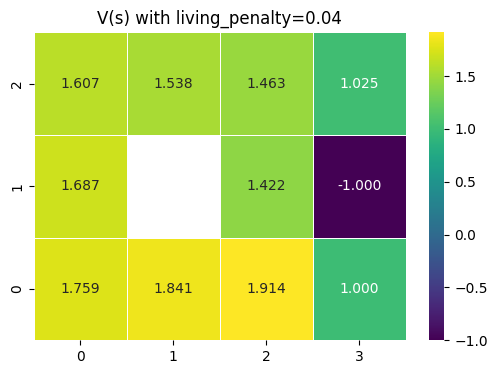


Extracted Policy (living_penalty=0.04)
> > > G
^ # ^ P
^ < < <

Running Value Iteration with living_penalty = 0.0  (stored as reward=-0.000 for non-terminal states)

Final value function V(s) (rows top->bottom):


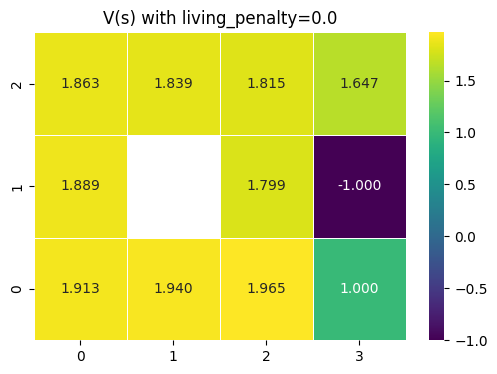


Extracted Policy (living_penalty=0.0)
> > > G
^ # < P
^ < < v

Running Value Iteration with living_penalty = 0.5  (stored as reward=-0.500 for non-terminal states)

Final value function V(s) (rows top->bottom):


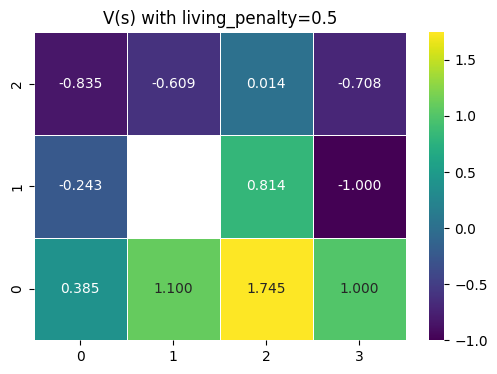


Extracted Policy (living_penalty=0.5)
> > > G
^ # ^ P
^ > ^ <



In [14]:
gamma = 0.99
theta = 1e-4

V_default, policy_default, R_default = run_experiment(living_penalty=0.04, gamma=gamma, theta=theta)

V_no_penalty, policy_no_penalty, R_no_penalty = run_experiment(living_penalty=0.0, gamma=gamma, theta=theta)

V_high_penalty, policy_high_penalty, R_high_penalty = run_experiment(living_penalty=0.5, gamma=gamma, theta=theta)


Q1: With small living penalty (0.04):
- The agent should prefer shortest routes to the goal and avoid the pit.
- Look at the policy arrows and the value heatmap: the policy points toward the goal while steering clear of the pit.
- The pit has strongly negative value; the goal has positive value. Non-terminal cells have intermediate values.


Q2: With living penalty = 0.0 (no per-step cost):
- Observation: With no step cost the agent only cares about reaching the goal vs falling in pit, so longer routes that still eventually reach the goal may be considered acceptable.
- In practice, the optimal policy may not change drastically for this tiny grid; it will still avoid the pit but may not be as 'shortest-path' focused.
- Compare the arrow grids printed above (default vs no_penalty) to see any subtle differences.

Q3: With living penalty = 0.5 (high step cost):
- Observation: When per-step cost is large, the agent is strongly incentivized to reach the terminal quickly.
- This often results in more aggressive shortest-path policies; the agent may take risky moves if they reduce expected steps, but since the pit is a very negative terminal the agent tends to still avoid it if risk is too high.
- In short: increasing living penalty emphasizes minimizing path length; decreasing it (to 0) emphasizes more asymptotic value to reach goal and avoid pit.
